**When using GG Colab**

In [ ]:
# If using GG Colab, you need to upload file kaggle.json
from google.colab import files
files.upload()

In [ ]:
# Create a folder .kaggle
!mkdir -p ~/.kaggle
# Put the file kaggle.json into that folder
!cp kaggle.json ~/.kaggle/
# Config ...
!chmod 600 ~/.kaggle/kaggle.json

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import os
import kaggle

# Import Dataset

https://www.kaggle.com/datasets/sayedmahmoud/alpaca-dataset

In [ ]:
dataset_url = 'sayedmahmoud/alpaca-dataset'
download_path = './alpaca_dataset'

if os.path.isdir(download_path) and any(os.scandir(download_path)):
    print(f'Dataset already exists in {download_path}')
else:
    print(f'Downloading dataset from Kaggle: {dataset_url}')
    kaggle.api.dataset_download_files(dataset_url, path=download_path, unzip=True)
    print(f'Dataset downloaded and extracted to {download_path}')

Dataset already exists in ./alpaca_dataset


In [ ]:
train_path = './alpaca_dataset/dataset/train/'
test_path = './alpaca_dataset/dataset/test/'

BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)  # without channels

# Load training dataset
train_dataset = keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle the train set
    label_mode='int'  # Use 'int' if you want integer labels, 'categorical' for one-hot encoding
)

# Load test dataset
test_dataset = keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle the test set
    label_mode='int'
)

Found 250 files belonging to 2 classes.
Found 77 files belonging to 2 classes.


In [ ]:
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Data Exploration

In [ ]:
classes = train_dataset.class_names
classes

['alpaca', 'not_alpaca']

In [ ]:
from collections import Counter

# Extract labels from train dataset
y_train = np.concatenate([y.numpy() for _, y in train_dataset], axis=0)
y_test = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

# Count class occurrences
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("Class counts in train dataset:", train_counts)
print("Class counts in test dataset:", test_counts)


Class counts in train dataset: Counter({1: 142, 0: 108})
Class counts in test dataset: Counter({1: 43, 0: 34})


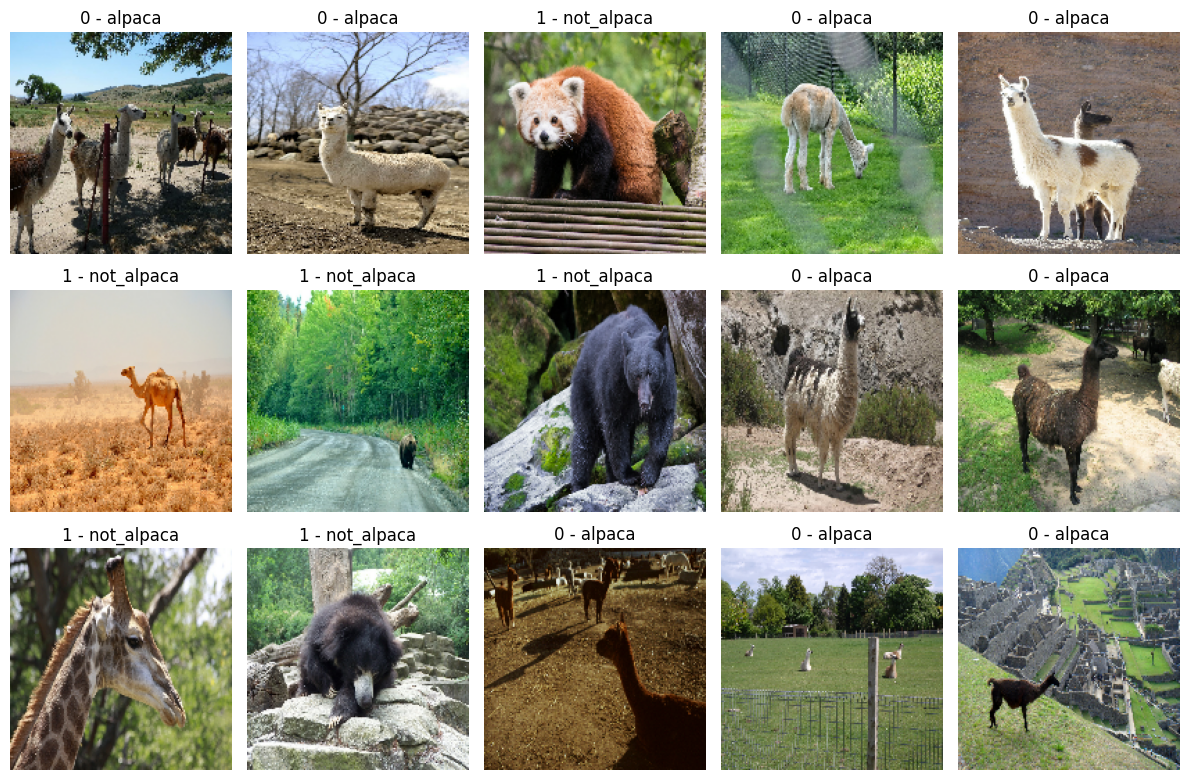

In [ ]:
n_rows = 3
n_cols = 5

plt.figure(figsize=(12, 8))
for images, labels in train_dataset.take(1):
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))  # uint8 is a data type used to represent integer values from 0 to 255.
        plt.title(f'{labels[i].numpy()} - {classes[labels[i].numpy()]}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Augment Data

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
def augment_data():
    augmenter = keras.Sequential()
    augmenter.add(keras.layers.RandomFlip(mode='horizontal'))
    augmenter.add(keras.layers.RandomRotation(factor=0.25))  # 25% of 180 degrees
    augmenter.add(keras.layers.RandomZoom(height_factor=0.25, width_factor=0.25))
    augmenter.add(keras.layers.RandomContrast(factor=0.25))  # Adjust contrast by a factor between 0.75 and 1.25
    return augmenter

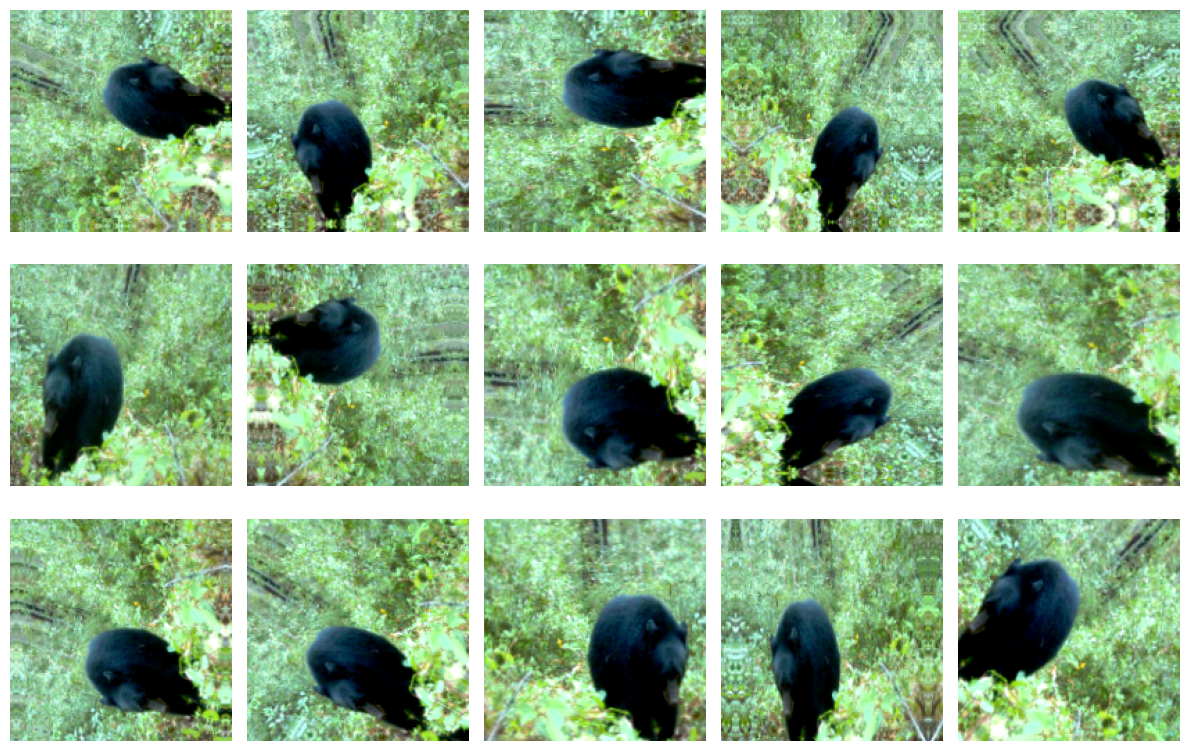

In [ ]:
n_rows = 3
n_cols = 5

plt.figure(figsize=(12, 8))
for images, _ in train_dataset.take(1):
    img = images[0]
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i+1)
        augmented_img = augment_data()(tf.expand_dims(img, axis=0))
        plt.imshow(augmented_img[0].numpy().astype('uint8'))  # uint8 is a data type used to represent integer values from 0 to 255.
        plt.axis('off')

plt.tight_layout()
plt.show()

# Building model based on MobileNetV2

In [ ]:
INPUT_SHAPE = IMAGE_SIZE + (3,)  # adding channels
INPUT_SHAPE

(160, 160, 3)

In [ ]:
def Custom_MobileNetV2(input_shape, augmenter_func):
    # Drop the last layer
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False
    )

    # Freeze the base model by making it non-trainable
    base_model.trainable = False

    # Create the input layer
    inputs = keras.Input(shape=input_shape)

    # Apply data augmentation to the inputs
    augmented_inputs = augmenter_func(inputs)

    # For MobileNetV2, call `mobilenet_v2.preprocess_input` on your inputs before passing them to the model.
    # It will scale input pixels between -1 and 1.
    scaled_inputs = keras.applications.mobilenet_v2.preprocess_input(augmented_inputs)

    # Set training to False to avoid keeping track of statistics in the batch norm layer
    output_of_baseModel = base_model(scaled_inputs, training=False)  # output is a conv layer

    # Global Average Pooling turns each channel into a scalar value so no need to flatten
    A0 = keras.layers.GlobalAveragePooling2D()(output_of_baseModel)

    # Include dropout with the probability of 0.2 to avoid overfitting
    dropOut = keras.layers.Dropout(0.2)(A0)

    # Binary Classification
    outputs = keras.layers.Dense(units=1)(dropOut)

    # A complete model
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = Custom_MobileNetV2(
    input_shape=INPUT_SHAPE,
    augmenter_func=augment_data()
)

In [ ]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training

### For intial epochs, I just freeze the MobileNetV2 and train only the last added layers

In [ ]:
LR = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
INITIAL_EPOCHS = 5

history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=test_dataset
                    )

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - accuracy: 0.4207 - loss: 0.9299 - val_accuracy: 0.4545 - val_loss: 0.8299
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.5802 - loss: 0.7284 - val_accuracy: 0.5974 - val_loss: 0.6555
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.5806 - loss: 0.6822 - val_accuracy: 0.6494 - val_loss: 0.5777
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.6827 - loss: 0.5727 - val_accuracy: 0.6623 - val_loss: 0.5310
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.7629 - loss: 0.4789 - val_accuracy: 0.6883 - val_loss: 0.4940


In [ ]:
history.epoch

[0, 1, 2, 3, 4]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

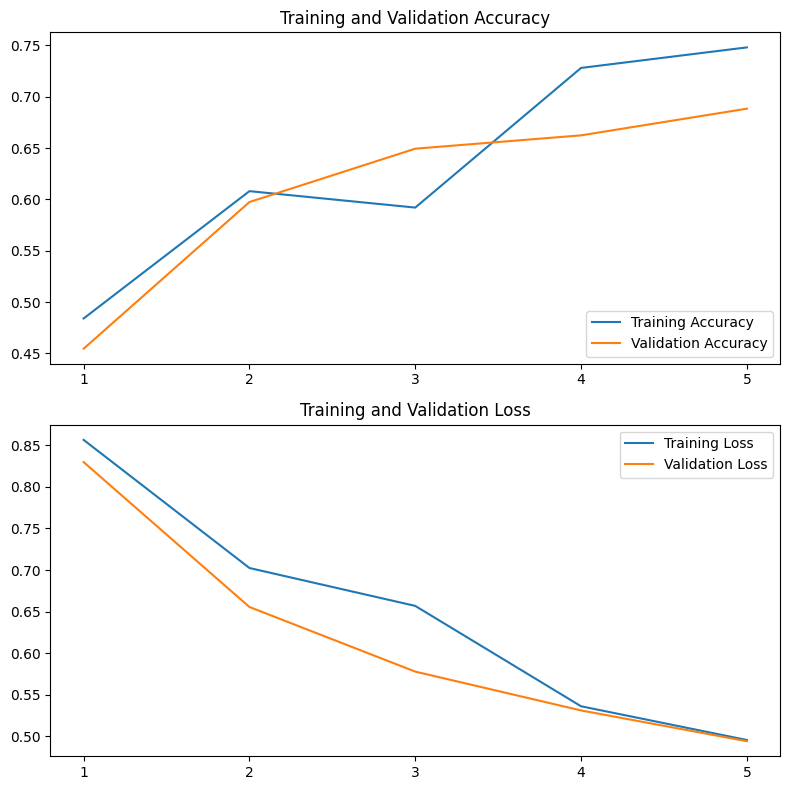

In [ ]:
plt.figure(figsize=(8, 8))

# Accuracy
plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(ticks=range(len(acc)), labels=range(1, len(acc)+1))

# Loss
plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks(ticks=range(len(loss)), labels=range(1, len(loss)+1))

#
plt.tight_layout()
plt.show()

### I notice the sign of overfitting, so I will unfreeze some last layers of MobileNetV2 to train them

In [ ]:
model.layers

[<InputLayer name=input_layer_16, built=True>,
 <Sequential name=sequential_15, built=True>,
 <Functional name=mobilenetv2_1.00_160, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense, built=True>]

In [ ]:
base_model = model.layers[2]
base_model

<Functional name=mobilenetv2_1.00_160, built=True>

In [ ]:
def count_layers(model):
    total_layers = len(model.layers)
    trainable_layers = [layer for layer in model.layers if layer.trainable == True]
    n_trainable = len(trainable_layers)
    print(f'Total Layers = {total_layers}')
    print(f'Trainable Layers = {n_trainable}')
    return None

# No trainable layers because we freezed the entire base_model which is MobileNetV2
count_layers(base_model)

Total Layers = 154
Trainable Layers = 0


In [ ]:
# Freeze all the layers before the `train_at` layer
train_at = 120
for layer in base_model.layers[train_at: ]:
    layer.trainable = True

count_layers(base_model)

Total Layers = 154
Trainable Layers = 34


In [ ]:
"""
When you unfreeze layers (set them to be trainable), this changes the trainable status of the model,
and Keras needs to recompile to know which layers are now trainable and which ones are frozen.
"""

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR*0.1),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
NEXT_EPOCHS = 5
TOTAL_EPOCHS =  INITIAL_EPOCHS + NEXT_EPOCHS

next_history = model.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=test_dataset,
    initial_epoch = history.epoch[-1] + 1
)

Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 472ms/step - accuracy: 0.6954 - loss: 0.5571 - val_accuracy: 0.6623 - val_loss: 0.4350
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.7998 - loss: 0.3753 - val_accuracy: 0.8312 - val_loss: 0.3015
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.8885 - loss: 0.2624 - val_accuracy: 0.9091 - val_loss: 0.2419
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.8793 - loss: 0.2710 - val_accuracy: 0.9091 - val_loss: 0.2298
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.8415 - loss: 0.2516 - val_accuracy: 0.8961 - val_loss: 0.2206


In [ ]:
next_history.epoch

[5, 6, 7, 8, 9]

In [ ]:
acc += next_history.history['accuracy']
val_acc += next_history.history['val_accuracy']

loss += next_history.history['loss']
val_loss += next_history.history['val_loss']

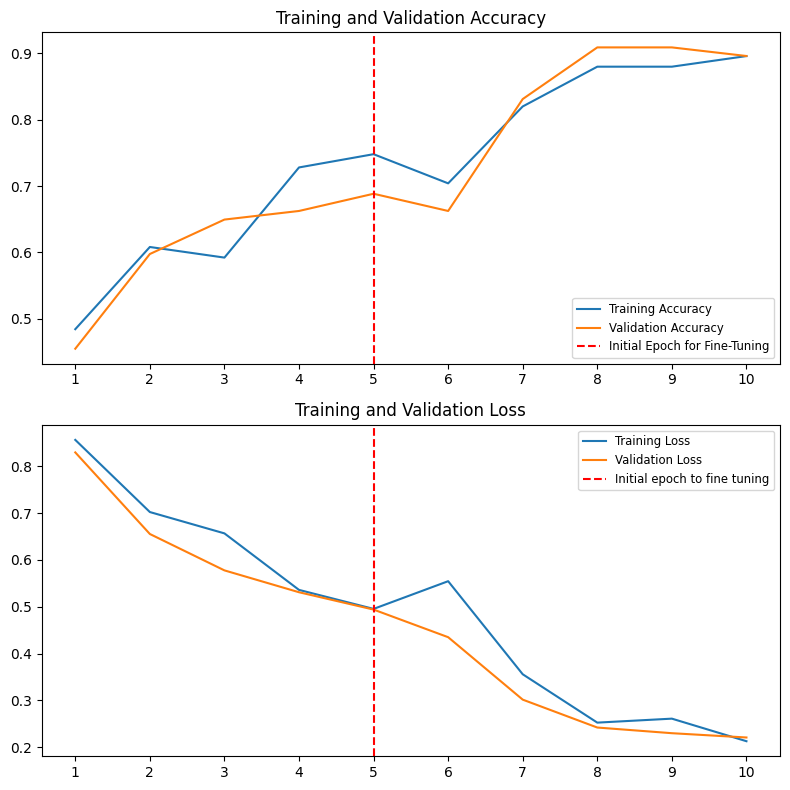

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=history.epoch[-1],color='r', linestyle='--', label='Initial Epoch for Fine-Tuning')  # Add vertical line
plt.legend(loc='lower right', fontsize='small')
plt.xticks(ticks=range(len(acc)), labels=range(1, len(acc)+1))

plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=history.epoch[-1],color='r', linestyle='--', label='Initial epoch to fine tuning')  # Add vertical line
plt.legend(loc='upper right', fontsize='small')
plt.xticks(ticks=range(len(loss)), labels=range(1, len(loss)+1))

plt.tight_layout()
plt.show()

- After unfreeze some last layers, I have improved the performance of model. There are no signs of overfitting now.

# Model Evaluation

In [ ]:
X_test = np.concatenate([x.numpy() for x, _ in test_dataset], axis=0)

prob = model.predict(X_test)
prob.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step


(77, 1)

In [ ]:
Y_predict = (prob > 0.5).astype(int).flatten()
Y_predict.shape

(77,)

In [ ]:
Y_test = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
Y_test.shape

(77,)

In [ ]:
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        34
           1       0.95      0.86      0.90        43

    accuracy                           0.90        77
   macro avg       0.90      0.90      0.90        77
weighted avg       0.90      0.90      0.90        77



- All metrics are good

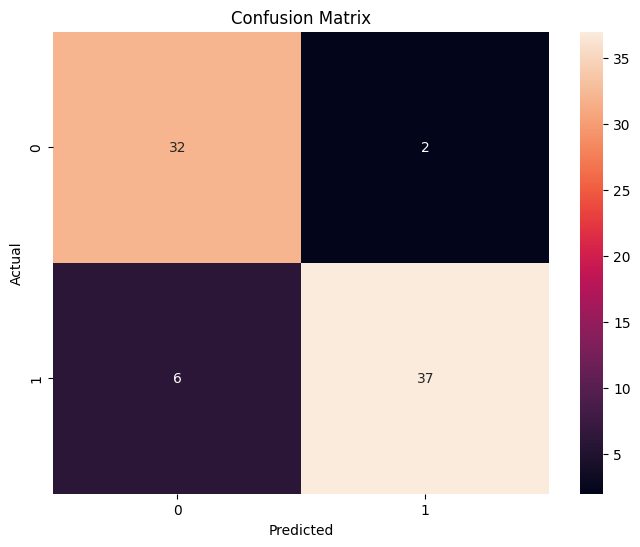

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_predict)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()